In [4]:
import os
import cv2
import numpy as np

In [30]:
input_folder = "./cellpose_train/"
img_list = [img for img in os.listdir(input_folder) if '.png' in img and 'mask' not in img]
mask_list = [mask for mask in os.listdir(input_folder) if 'masks.png' in mask]

In [31]:
len(img_list)

540

In [32]:
len(mask_list)

540

In [71]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core
from cellpose import utils

use_GPU = core.use_gpu()
# print('>>> GPU activated? %d'%use_GPU)

# # call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

files = ['../test_data/test_imgs_single_nuclei/0701_reg001_cyc002_ch001_DAPI-02_13.png']

imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

model = models.Cellpose(gpu=use_GPU, model_type='cyto')

channels = [[0,0]]

masks, flows, styles, diams = model.eval(imgs, diameter=None, flow_threshold=None, channels=channels)

masks = [_masks.astype('int32') for _masks in masks]

2022-02-22 14:07:47,703 [INFO] ** TORCH CUDA version installed and working. **
2022-02-22 14:07:47,706 [INFO] WRITING LOG OUTPUT TO /home/master/09/chacotw/.cellpose/run.log
2022-02-22 14:07:47,716 [INFO] ** TORCH CUDA version installed and working. **
2022-02-22 14:07:47,717 [INFO] >>>> using GPU
2022-02-22 14:07:47,809 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2022-02-22 14:07:51,335 [INFO] estimated cell diameter(s) in 3.53 sec
2022-02-22 14:07:51,338 [INFO] >>> diameter(s) = 
2022-02-22 14:07:51,339 [INFO] [17.09, ]
2022-02-22 14:07:51,340 [INFO] ~~~ FINDING MASKS ~~~
2022-02-22 14:07:53,624 [INFO] >>>> TOTAL TIME 5.82 sec


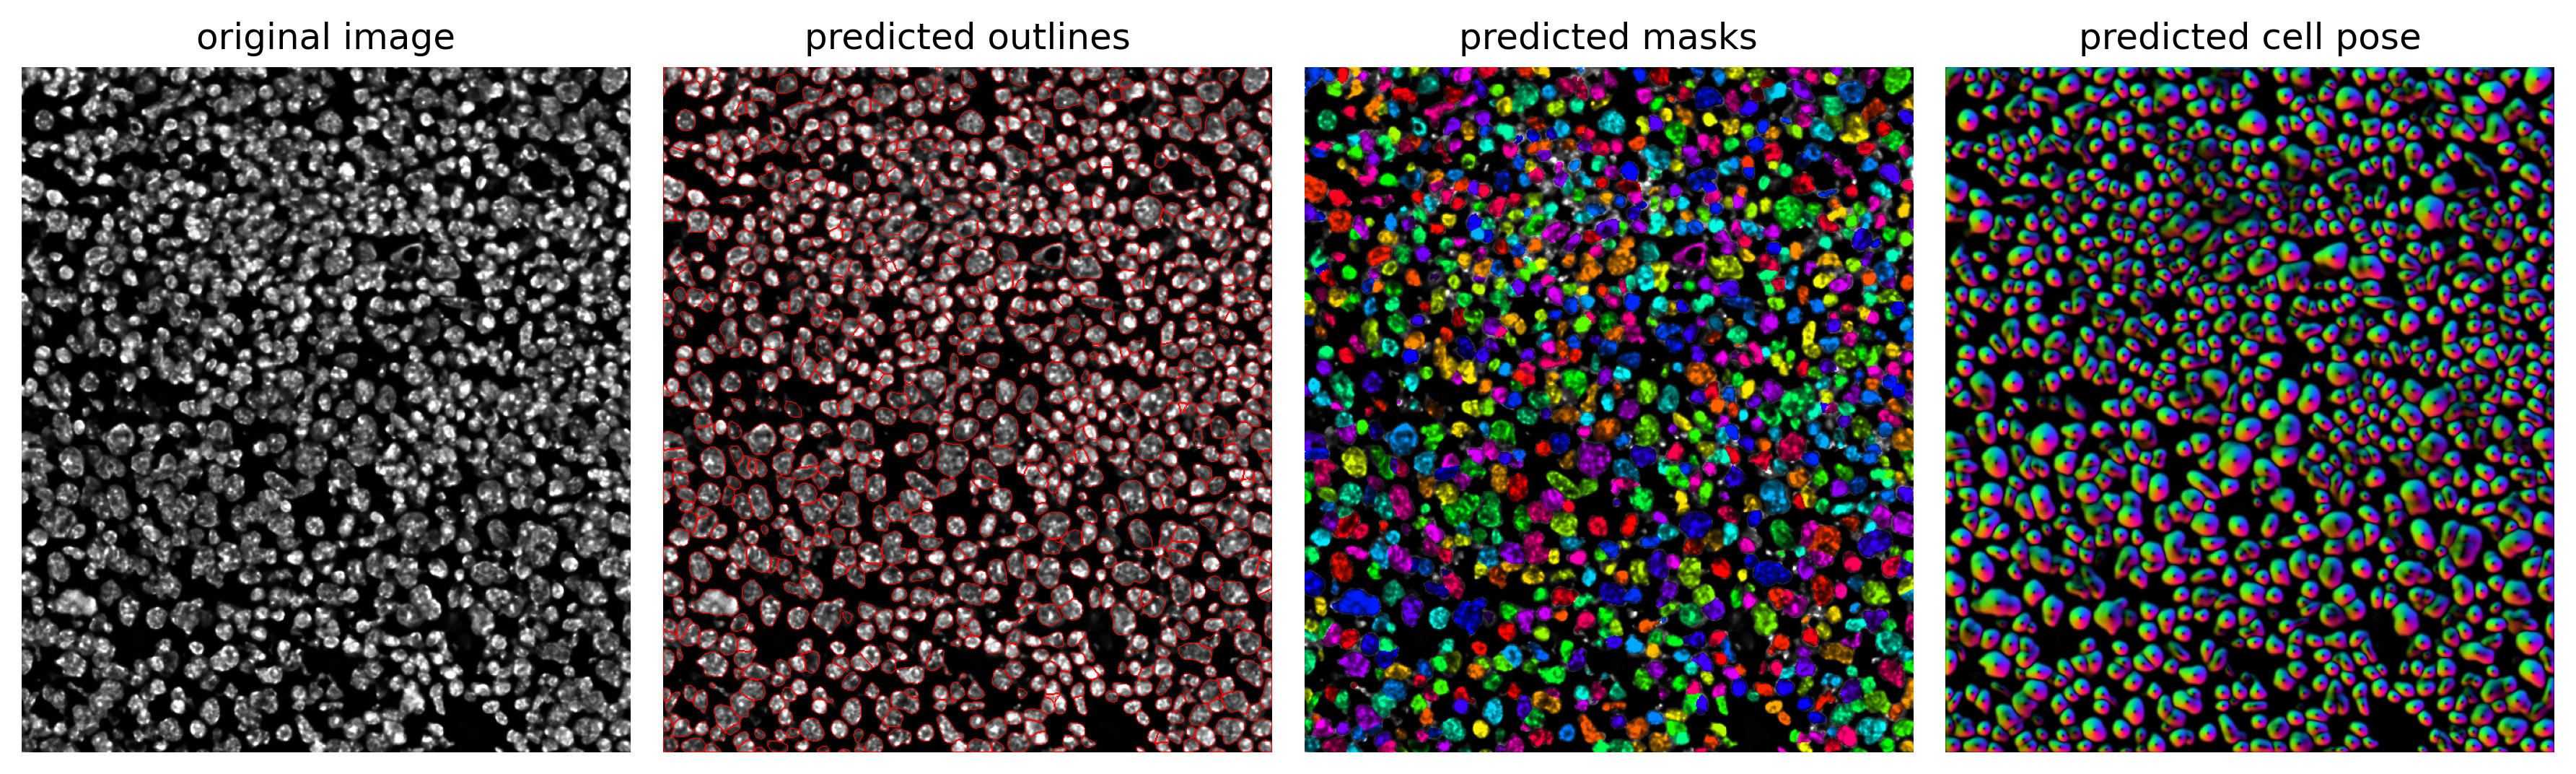

In [73]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

In [74]:
cv2.imwrite("ASDF1.png",((masks[0])))

True

In [75]:
masks[0].dtype

dtype('int32')

In [9]:
import cv2
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import lstsq
from scipy.spatial import distance
from skimage.measure import find_contours
from skimage.morphology import disk, dilation
from scipy.ndimage.morphology import binary_dilation
from scipy.spatial.distance import cdist

import json

2022-02-22 12:03:23,328 [INFO] Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [78]:
def grow_masks(input_masks, bb_mins, bb_maxes,growth, num_neighbors = 30):


#     print("Standard growth selected")
    masks = input_masks
    num_masks = len(np.unique(masks)) - 1
#     print(num_masks)
#     indices = np.where(masks != 0)
#     values = masks[indices[0], indices[1]]

#     maskframe = pd.DataFrame(np.transpose(np.array([indices[0], indices[1], values]))).rename(columns = {0:"x", 1:"y", 2:"id"})
#     cent_array = maskframe.groupby('id').agg({'x': 'mean', 'y': 'mean'}).to_numpy()
    
#     #print("cent_array", cent_array)
    
#     connectivity_matrix = kneighbors_graph(cent_array, num_neighbors).toarray() * np.arange(1, num_masks + 1)
#     connectivity_matrix = connectivity_matrix.astype(int)
#     labels = {}
#     for n in range(num_masks):
#         connections = list(connectivity_matrix[n, :])
#         connections.remove(0)
#         layers_used = [labels[i] for i in connections if i in labels]
#         layers_used.sort()
#         currlayer = 0
#         for layer in layers_used:
#             if currlayer != layer: 
#                 break
#             currlayer += 1
#         labels[n + 1] = currlayer

#     possible_layers = len(list(set(labels.values())))
#     print(possible_layers)
#     label_frame = pd.DataFrame(list(labels.items()), columns = ["maskid", "layer"])
#     image_h, image_w = masks.shape
#     expanded_masks = np.zeros((image_h, image_w, possible_layers), dtype = np.uint32)
    
#     print(expanded_masks.shape)

#     grouped_frame = label_frame.groupby('layer')
#     for layer, group in grouped_frame:
#         currids = list(group['maskid'])
#         masklocs = np.isin(masks, currids)
#         expanded_masks[masklocs, layer] = masks[masklocs]

#     dilation_mask = disk(1)
#     grown_masks = np.copy(expanded_masks)
#     for _ in range(growth):
#         for i in range(possible_layers):
#             grown_masks[:, :, i] = dilation(grown_masks[:, :, i], dilation_mask)
            
#     grown_masks = remove_overlaps_nearest_neighbors(cent_array, grown_masks)
    
#     return cent_array, grown_masks
    print("Sequential growth selected")
    Y, X = masks.shape
    struc = disk(1)
    for _ in range(growth):
        for i in range(num_masks):
            mins = bb_mins[i]
            maxes = bb_maxes[i]
            minY, minX, maxY, maxX = mins[0] - 3*growth, mins[1] - 3*growth, maxes[0] + 3*growth, maxes[1] + 3*growth
            if minX < 0: minX = 0
            if minY < 0: minY = 0
            if maxX >= X: maxX = X - 1
            if maxY >= Y: maxY = Y - 1

            currreg = masks[minY:maxY, minX:maxX]
            mask_snippet = (currreg == i + 1)
            full_snippet = currreg > 0
            other_masks_snippet = full_snippet ^ mask_snippet
            dilated_mask = binary_dilation(mask_snippet, struc)
            final_update = (dilated_mask ^ full_snippet) ^ other_masks_snippet

            #f, axarr = plt.subplots(1, 5)
            #plt.imshow(mask_snippet)
            #axarr[0].imshow(mask_snippet)
            #axarr[1].imshow(full_snippet)
            #axarr[2].imshow(other_masks_snippet)
            #axarr[3].imshow(dilated_mask)
            #axarr[4].imshow(final_update)
            #plt.show()

            pix_to_update = np.nonzero(final_update)

            pix_X = np.array([min(j + minX, X) for j in pix_to_update[1]])
            pix_Y = np.array([min(j + minY, Y) for j in pix_to_update[0]])

            masks[pix_Y, pix_X] = i + 1

    return masks


In [79]:
def remove_overlaps_nearest_neighbors(centroids ,masks):
    final_masks = np.max(masks, axis = 2)
    
    collisions = np.nonzero(np.sum(masks > 0, axis = 2) > 1)
    collision_masks = masks[collisions]
    collision_index = np.nonzero(collision_masks)
    collision_masks = collision_masks[collision_index]
    collision_frame = pd.DataFrame(np.transpose(np.array([collision_index[0], collision_masks]))).rename(columns = {0:"collis_idx", 1:"mask_id"})
    grouped_frame = collision_frame.groupby('collis_idx')
    for collis_idx, group in grouped_frame:
        collis_pos = np.expand_dims(np.array([collisions[0][collis_idx], collisions[1][collis_idx]]), axis = 0)
        prevval = final_masks[collis_pos[0,0], collis_pos[0,1]]
        mask_ids = list(group['mask_id'])
        curr_centroids = np.array([centroids[mask_id - 1] for mask_id in mask_ids])
        dists = cdist(curr_centroids, collis_pos)
        closest_mask = mask_ids[np.argmin(dists)]
        final_masks[collis_pos[0,0], collis_pos[0,1]] = closest_mask

    return final_masks
             

In [80]:
def compute_boundbox(masks):
    
    num_masks = len(np.unique(masks)) - 1
    indices = np.where(masks != 0)
    values = masks[indices[0], indices[1]]

    maskframe = pd.DataFrame(np.transpose(np.array([indices[0], indices[1], values]))).rename(columns = {0:"y", 1:"x", 2:"id"})
    bb_mins = maskframe.groupby('id').agg({'y': 'min', 'x': 'min'}).to_records(index = False).tolist()
    bb_maxes = maskframe.groupby('id').agg({'y': 'max', 'x': 'max'}).to_records(index = False).tolist()
    
    return bb_mins, bb_maxes

In [ ]:

             
    def grow_masks(self, growth, method = 'Standard', num_neighbors = 30):
        assert method in ['Standard', 'Sequential']
        
        masks = self.flatmasks
        
        print("mask (flatmasks.shape) = ", masks.shape)
        
        num_masks = len(np.unique(masks)) - 1
        
        if method == 'Standard':
            print("Standard growth selected")
            masks = self.flatmasks
            num_masks = len(np.unique(masks)) - 1
            indices = np.where(masks != 0)
            values = masks[indices[0], indices[1]]

            maskframe = pd.DataFrame(np.transpose(np.array([indices[0], indices[1], values]))).rename(columns = {0:"x", 1:"y", 2:"id"})
            cent_array = maskframe.groupby('id').agg({'x': 'mean', 'y': 'mean'}).to_numpy()
            
            print("cent_array inside = ",cent_array)
            
            connectivity_matrix = kneighbors_graph(cent_array, num_neighbors).toarray() * np.arange(1, num_masks + 1)
            connectivity_matrix = connectivity_matrix.astype(int)
            labels = {}
            for n in range(num_masks):
                connections = list(connectivity_matrix[n, :])
                connections.remove(0)
                layers_used = [labels[i] for i in connections if i in labels]
                layers_used.sort()
                currlayer = 0
                for layer in layers_used:
                    if currlayer != layer: 
                        break
                    currlayer += 1
                labels[n + 1] = currlayer

            possible_layers = len(list(set(labels.values())))
            label_frame = pd.DataFrame(list(labels.items()), columns = ["maskid", "layer"])
            
            print("label_frame = ",label_frame)
            
            image_h, image_w = masks.shape
            expanded_masks = np.zeros((image_h, image_w, possible_layers), dtype = np.uint32)

            grouped_frame = label_frame.groupby('layer')
            for layer, group in grouped_frame:
                currids = list(group['maskid'])
                masklocs = np.isin(masks, currids)
                expanded_masks[masklocs, layer] = masks[masklocs]

            dilation_mask = disk(1)
            grown_masks = np.copy(expanded_masks)
            
            print("expanded masks shape = ",expanded_masks.shape)
            
            for _ in range(growth):
                for i in range(possible_layers):
                    grown_masks[:, :, i] = dilation(grown_masks[:, :, i], dilation_mask)
            self.flatmasks = self.remove_overlaps_nearest_neighbors(grown_masks)


In [81]:
bb_mins, bb_maxes = compute_boundbox(masks[0])

In [84]:
#cents, growed_masks = grow_masks(masks, growth = 15, num_neighbors = 30)
growed_masks = grow_masks(masks[0], bb_mins, bb_maxes, growth = 15, num_neighbors = 30)

Sequential growth selected


In [85]:
growed_masks.dtype

dtype('int32')

In [86]:
cv2.imwrite("WTF15.png",growed_masks)#.astype('uint8'))

True

In [ ]:
final_masks = np.max(growed_masks, axis = 2).astype('uint8')

In [87]:
def geojson_format(coords):
    
    geojson_list = []
    for coord in coords:
        coord = np.squeeze(coord).tolist()
        geojson = {
        "type": "Feature",
        "id": "PathAnnotationObject",
        "geometry": {
          "type": "Polygon",
          "coordinates": [coord]
        },
        "properties": {
          "isLocked": False,
          "measurements": []
        }
      }
        
        geojson_list.append(geojson)
    
    return geojson_list

In [88]:
res = []
blank = np.zeros((756, 672))
for i in range(1,len(np.unique(growed_masks)) - 1):
    _mask = np.array((growed_masks == i)*255, dtype = "uint8")
    checked_cnts = []
    contours,hierarchy = cv2.findContours(_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    for cnt in contours:
        mask_area = cv2.contourArea(cnt)

        if mask_area > 0:
            checked_cnts.append(cnt)
        else:
            print("No. {} less than 50".format(i), mask_area)
    cv2.drawContours(blank, checked_cnts , -1, 255)

    res.extend(checked_cnts)

In [16]:
final = geojson_format(res)
img_name = "full_img_cnts_5"
with open("./{}.json".format(img_name), 'w', encoding='utf-8') as f:
    json.dump(final, f, ensure_ascii=False, indent=4)

In [89]:
cv2.imwrite("cnt15.png",blank)

True